In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install torch torchaudio transformers scikit-learn matplotlib


In [4]:
import os

# Dosya yollarını listeleme
base_path = "/content/drive/MyDrive/Yazgel_Muzik_Secilen_1000"
folders = ["huzunlu", "neseli", "agresif"]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    print(f"{folder} klasörü dosyaları:")
    for file in os.listdir(folder_path):
        print(f"  - {file}")


huzunlu klasörü dosyaları:
  - Onur Can Özcan - Hırka_chunk0_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk15_resampled.wav
  - Onur Can Özcan - Hırka_chunk5_resampled.wav
  - Onur Can Özcan - Hırka_chunk2_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk6_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk9_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk4_resampled.wav
  - Orhan Gencebay-batsın bu dünya_chunk11_resampled.wav
  - Orhan Gencebay-batsın bu dünya_chunk14_resampled.wav
  - Orhan Gencebay-batsın bu dünya_chunk9_resampled.wav
  - Onur Can Özcan - Hırka_chunk14_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk3_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk7_resampled.wav
  - Onur Can Özcan - Hırka_chunk4_resampled.wav
  - Orhan Gencebay - Dertler Benim Olsun (1973)_chunk18_resampled.wav
  - Orhan Gencebay-batsın bu dünya_chunk0_resampled.wav
  - Onur Can

In [5]:
import glob

base_path = "/content/drive/MyDrive/Yazgel_Muzik_Secilen_1000"
folders = ["huzunlu", "neseli", "agresif"]

audio_paths = []
labels = []

for label, folder in enumerate(folders):  # 0: huzunlu, 1: neseli, 2: agresif
    folder_path = f"{base_path}/{folder}"
    resampled_files = glob.glob(f"{folder_path}/*_resampled.wav")  # Resampled dosyaları seç
    audio_paths.extend(resampled_files)
    labels.extend([label] * len(resampled_files))

print(f"Toplam {len(audio_paths)} dosya bulundu.")



  - Ricky Remedy - YRTN (feat Ralph)_chunk19_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk0_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk4_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk7_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk1_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk6_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk13_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk12_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk10_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk15_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk11_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk18_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk13_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk6_chunk0_resampled.wav
  - Ricky Remedy - Break It Down_chunk12_chunk0_resampled.wav
  - Ricky Remedy - YRTN (feat Ralph)_chunk1

Toplam 3010 dosya bulundu.


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 0.9472298352821324
Validation Loss: 0.8371046171677823, Accuracy: 61.63%
Epoch 2, Training Loss: 0.771500318153356
Validation Loss: 0.7093174207881586, Accuracy: 68.77%
Epoch 3, Training Loss: 0.6878733080486918
Validation Loss: 0.6627816910183193, Accuracy: 70.27%
Confusion Matrix:
[[167  42   9]
 [ 13 135  27]
 [  5  83 121]]
Accuracy: 0.70, Precision: 0.73, Recall (Sensitivity): 0.71, F1-Score: 0.70, Specificity: 0.73, AUC: 0.78


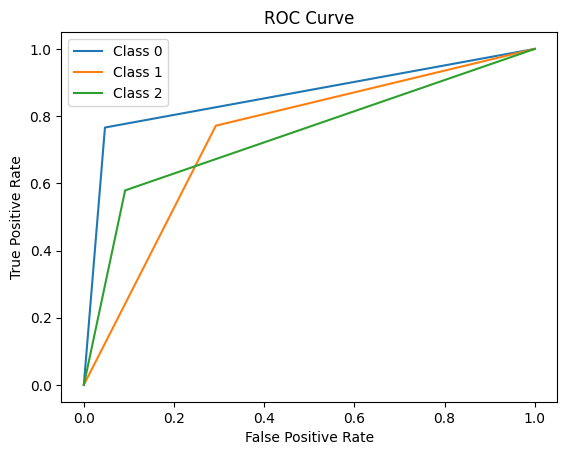

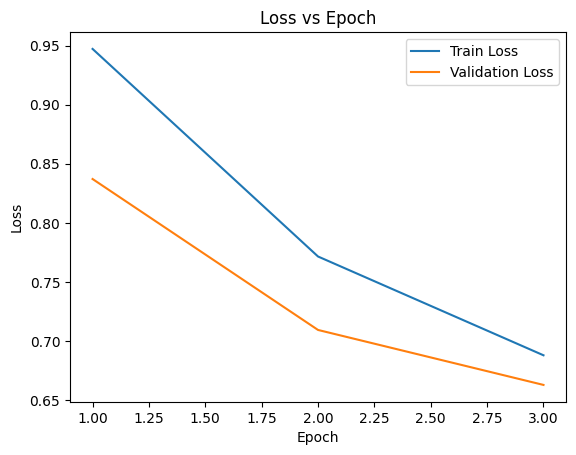

Training Time: 1594.19 seconds


In [6]:
from transformers import HubertForSequenceClassification, Wav2Vec2Processor
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score,
    recall_score, f1_score, accuracy_score
)
from sklearn.preprocessing import label_binarize
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import time

# Eğitim ve çıkarım zamanı hesaplama için timer
start_time = time.time()

# **1. Verilerin Hazırlanması**
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        inputs = preprocess_audio(self.audio_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs, label

# Güncellenmiş preprocess_audio fonksiyonu
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
def preprocess_audio(audio_path):
    """
    Resampled wav dosyalarını doğrudan yükler ve modele uygun hale getirir.
    """
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        raise ValueError(f"Dosya {audio_path} 16kHz örnekleme oranında değil!")
    inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs

# **2. Verilerin Tanımlanması**
base_path = "/content/drive/MyDrive/Yazgel_Muzik_Secilen_1000"
folders = ["huzunlu", "neseli", "agresif"]

audio_paths = []
labels = []

for label, folder in enumerate(folders):  # 0: huzunlu, 1: neseli, 2: agresif
    folder_path = f"{base_path}/{folder}"
    resampled_files = glob.glob(f"{folder_path}/*_resampled.wav")  # Sadece resampled dosyaları seç
    audio_paths.extend(resampled_files)
    labels.extend([label] * len(resampled_files))

print(f"Toplam {len(audio_paths)} dosya bulundu.")

from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(audio_paths, labels, test_size=0.2, random_state=42)

train_dataset = AudioDataset(train_paths, train_labels)
val_dataset = AudioDataset(val_paths, val_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# **3. Model, Optimizasyon ve Kayıp Fonksiyonu**
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=3)
model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

# **4. Eğitim ve Validasyon**
train_losses = []
val_losses = []

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        input_values = inputs["input_values"].mean(dim=1).to("cuda")
        attention_mask = inputs["attention_mask"][:, 0, :].to("cuda")
        labels = labels.to("cuda")

        with autocast(device_type="cuda"):
            outputs = model(input_values=input_values, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")

    # Validasyon
    model.eval()
    val_loss = 0
    correct = 0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            input_values = inputs["input_values"].mean(dim=1).to("cuda")
            attention_mask = inputs["attention_mask"][:, 0, :].to("cuda")
            labels = labels.to("cuda")

            outputs = model(input_values=input_values, attention_mask=attention_mask)
            val_loss += loss_fn(outputs.logits, labels).item()
            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / len(val_loader.dataset):.2f}%")

# **5. Performans Metrikleri**
conf_matrix = confusion_matrix(true_labels, predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
specificity = np.mean([
    conf_matrix[i, i] / (np.sum(conf_matrix[:, i]) - conf_matrix[i, i] + conf_matrix[i, i])
    for i in range(3)
])
auc = roc_auc_score(label_binarize(true_labels, classes=[0, 1, 2]), label_binarize(predictions, classes=[0, 1, 2]), multi_class="ovr")

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall (Sensitivity): {recall:.2f}, F1-Score: {f1:.2f}, Specificity: {specificity:.2f}, AUC: {auc:.2f}")

# **6. ROC Eğrisi ve Loss Grafiği**
for i in range(3):
    fpr, tpr, _ = roc_curve(label_binarize(true_labels, classes=[0, 1, 2])[:, i], label_binarize(predictions, classes=[0, 1, 2])[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

print(f"Training Time: {time.time() - start_time:.2f} seconds")
